In [1]:

import transformers
import torch
from vllm import LLM, SamplingParams
import os
from src.llm.PredictionUtils import init_model_and_tokenizer,llm_gen

os.environ["LIBRARY_PATH"]="/usr/local/cuda-12.2/lib64/stubs:$LIBRARY_PATH"
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"
lora_model="/data/hatakeyama/self-loop/0918repeat_prediction/output_200"

In [2]:
tensor_parallel_size = 8
#lora推論がうまくいかない
model= LLM(model=model_id,
           enable_lora=True,
        trust_remote_code=True,
        max_model_len=2000,
        tensor_parallel_size=tensor_parallel_size,
 max_lora_rank=64,
           )

INFO 09-18 21:41:33 config.py:904] Defaulting to use mp for distributed inference
INFO 09-18 21:41:33 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='meta-llama/Meta-Llama-3.1-70B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-70B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llam

Loading safetensors checkpoint shards:   0% Completed | 0/30 [00:00<?, ?it/s]


(VllmWorkerProcess pid=621577) INFO 09-18 21:41:53 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=621580) INFO 09-18 21:41:53 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=621576) INFO 09-18 21:41:54 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=621579) INFO 09-18 21:41:55 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=621581) INFO 09-18 21:41:55 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-18 21:41:55 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=621582) INFO 09-18 21:41:56 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=621578) INFO 09-18 21:41:57 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-18 21:42:04 distributed_gpu_executor.py:57] # GPU blocks: 81384, # CPU blocks: 6553
(VllmWorkerProcess pid=621577) INFO 09-18 21:42:07 

In [3]:
from vllm.lora.request import LoRARequest
#動作テスト
sampling_params = SamplingParams(
    temperature=0,
    max_tokens=256,
    #stop=["[/assistant]"]
)

prompts = [
     "hello!",
]

outputs = model.generate(
    prompts,
    sampling_params,
    lora_request=LoRARequest("adapter", 1, lora_path=lora_model)
)

/tmp/ipykernel_621004/1172514732.py:16: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  lora_request=LoRARequest("adapter", 1, lora_path=lora_model)
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it, est. speed input: 0.60 toks/s, output: 35.45 toks/s]


In [4]:

from datasets import load_dataset

ds=load_dataset("kanhatakeyama/material-properties",split="train")
ds=ds.shuffle(seed=1)
len(ds)

7241

In [5]:

train_ds=ds.select(range(7000))
test_ds=ds.select(range(7000,7200))
train_ds[0]


{'CompName': 'unknown',
 'SMILES': 'CC1=CC=C(C=C1)O',
 'Property': 'Vapor pressure',
 'Value': 0.11,
 'unit': '[kPa]',
 'Source': 'Wikipedia/Wikidata'}

In [6]:
import transformers
tokenizer=transformers.AutoTokenizer.from_pretrained(model_id)

In [7]:
import random
prompt_list=[]
problems=[]
for i in range(300):
    record=random.choice(train_ds)
    q=f"Predict "+record["Property"]+" "+record["unit"]+" for "+record["CompName"]+" (Compound X) with SMILES "+str(record["SMILES"])+". The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction."
    messages=[
        {"role": "user", "content": q},
    ]
    prompt=tokenizer.apply_chat_template(messages,tokenize=False)
    prompt_list.append(prompt+ "assistant\n\n#Reason\n")
    problems.append(record)

prompt_list[0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nPredict Boiling temperature [oC] for Boron trifluoride (Compound X) with SMILES FB(F)F. The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction.<|eot_id|>assistant\n\n#Reason\n'

In [8]:

outputs = model.generate(
    prompt_list,
    SamplingParams(
    temperature=0,
    max_tokens=1024,
),
    lora_request=LoRARequest("adapter", 1, lora_path=lora_model)
)

/tmp/ipykernel_621004/3862371218.py:7: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  lora_request=LoRARequest("adapter", 1, lora_path=lora_model)
Processed prompts: 100%|██████████| 300/300 [01:37<00:00,  3.09it/s, est. speed input: 326.29 toks/s, output: 796.75 toks/s]


In [9]:
predicted_texts=[i.outputs[0].text.strip() for i in outputs]
predicted_vals=[]
good_records=[]
for i in range(len(predicted_texts)):
    pred=predicted_texts[i].split("#Prediction")[-1]
    pred=pred.split(" [")[0].strip()

    strip_list=[
        "kJ/mol",
        "°C"," oC"," g/cm3"," g/cm"," eV"," cm^3/mol"," × 10^-6",
    ]
    for s in strip_list:
        pred=pred.split(s)[0].strip()

    if " " in pred:
        pred=pred.split(" ")[-1]
    if "\n" in pred:
        pred=pred.split("\n")[-1]
    if "**" in pred:
        pred=pred.split("**")[-1]
    
    predicted_vals.append(pred)

    problems[i]["predicted"]=pred
    problems[i]["predicted_text"]=predicted_texts[i]
    try:
        problems[i]["Value"]=float(problems[i]["Value"])
        error = abs((problems[i]["Value"]-float(problems[i]
                    ["predicted"]))/problems[i]["Value"])
        problems[i]["error_rate"] = error
        good_records.append(problems[i])
    except Exception as e:
        print(e)
        continue



could not convert string to float: '−101.3'
could not convert string to float: '130-140'
could not convert string to float: '50-60'
could not convert string to float: '200-250'
could not convert string to float: 'sample.'
could not convert string to float: '10^(-6)'
could not convert string to float: '200-250'
could not convert string to float: '120-150'
could not convert string to float: 'level.'
could not convert string to float: '120-140'
could not convert string to float: 'kPa'
could not convert string to float: '120-150'
could not convert string to float: '46-68'
could not convert string to float: '250-300'
could not convert string to float: 'conditions.'
could not convert string to float: 'forces.'
could not convert string to float: 'J/mol/K'
could not convert string to float: '150-200'
could not convert string to float: '120-150'
could not convert string to float: 'structure.'
could not convert string to float: '120-150'
could not convert string to float: '130-140'
could not con

<Axes: xlabel='error_rate', ylabel='Count'>

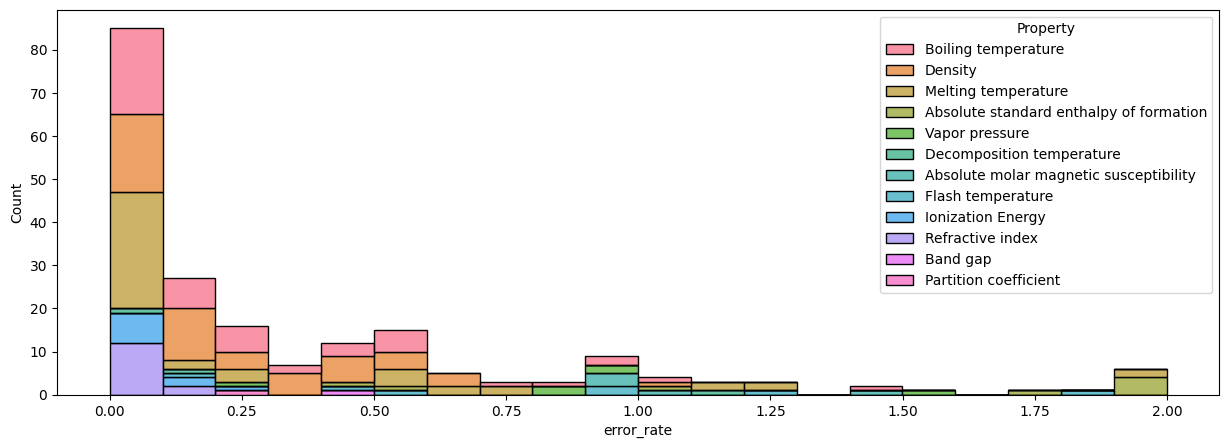

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.DataFrame(good_records)

plt.figure(figsize=(15, 5))
sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
             bins=20)

In [11]:
s_df=df[df["error_rate"]<2]
s_df["error_rate"].median(),s_df["error_rate"].mean(),df["error_rate"].median()

(0.1432038834951457, 0.36447764533238053, 0.21602787456445996)

In [12]:
df["predicted_text"][0],df["Value"][0],df["predicted"][0],df["error_rate"][0]

("To predict the absolute standard enthalpy of formation for Gallium(III) oxide (Ga2O3), we can use the following steps:\n\n1.  Look up the standard enthalpy of formation values for the elements in their standard states: The standard enthalpy of formation for Gallium is 0 kJ/mol (by definition, as it's an element in its standard state), and for oxygen, it's also 0 kJ/mol.\n2.  Look up the standard enthalpy of formation for Ga2O3: The standard enthalpy of formation for Ga2O3 is -1089 kJ/mol.\n\n#Prediction\n-1089 kJ/mol",
 5.12,
 '-1089',
 213.69531249999997)

In [47]:
# wo ft


outputs_ = model.generate(
    prompt_list,
    SamplingParams(
    temperature=0,
    max_tokens=1024,
),
    #lora_request=LoRARequest("adapter", 1, lora_path=lora_model)
)


Processed prompts: 100%|██████████| 300/300 [00:48<00:00,  6.14it/s, est. speed input: 640.22 toks/s, output: 1679.46 toks/s]


AttributeError: 'RequestOutput' object has no attribute 'outputs_'

could not convert string to float: '80-100'
could not convert string to float: '218-220'
could not convert string to float: '300-310'
could not convert string to float: '10^(-6)'
could not convert string to float: '250-300'
could not convert string to float: '250-300'
could not convert string to float: '180-200'
could not convert string to float: 'mPas'
could not convert string to float: '180-220'
could not convert string to float: '230-250'
could not convert string to float: 'kPa'
could not convert string to float: '250-300'
could not convert string to float: 'kPa'
could not convert string to float: 'kPa'
could not convert string to float: 'kPa'
could not convert string to float: '4-8'
could not convert string to float: 'kPa'
could not convert string to float: '220-250'
could not convert string to float: 'debye'
could not convert string to float: 'J/mol/K'
could not convert string to float: 'mPa·s'
could not convert string to float: '10^-6'
could not convert string to float: '12,800'


(0.09729334308705204, 0.30451782336009037, 0.15)

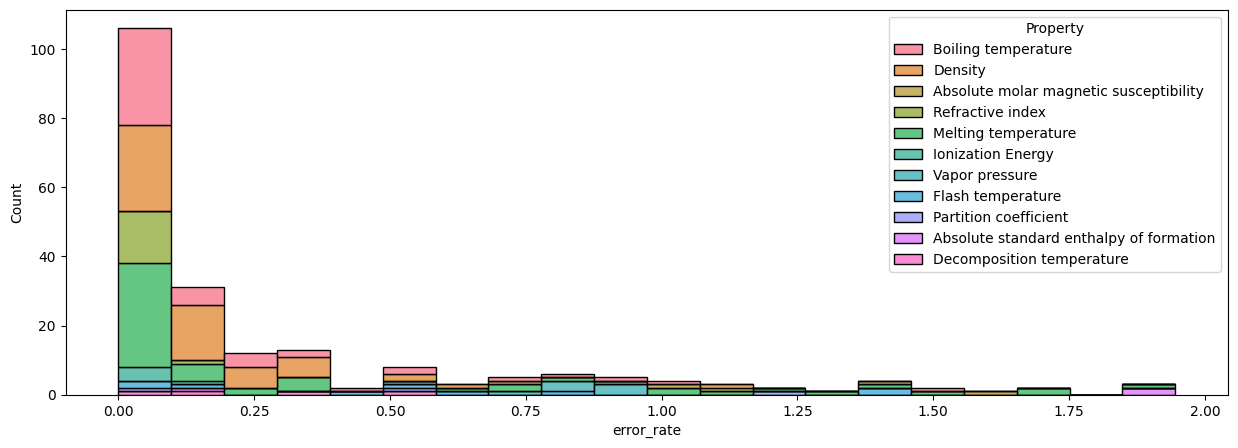

In [65]:

predicted_texts=[i.outputs[0].text.strip() for i in outputs_]
predicted_vals=[]
good_records=[]
for i in range(len(predicted_texts)):
    pred=predicted_texts[i].split("#Prediction")[-1]
    pred=pred.split(" [")[0].strip()

    strip_list=[
        "kJ/mol",
        "°C"," oC"," g/cm3"," g/cm"," eV"," cm^3/mol"," × 10^-6",
    ]
    for s in strip_list:
        pred=pred.split(s)[0].strip()

    if " " in pred:
        pred=pred.split(" ")[-1]
    if "\n" in pred:
        pred=pred.split("\n")[-1]
    if "**" in pred:
        pred=pred.split("**")[-1]
    
    predicted_vals.append(pred)

    problems[i]["predicted"]=pred
    problems[i]["predicted_text"]=predicted_texts[i]
    try:
        problems[i]["Value"]=float(problems[i]["Value"])
        error = abs((problems[i]["Value"]-float(problems[i]
                    ["predicted"]))/problems[i]["Value"])
        problems[i]["error_rate"] = error
        good_records.append(problems[i])
    except Exception as e:
        print(e)
        continue

df=pd.DataFrame(good_records)

plt.figure(figsize=(15, 5))
sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
             bins=20)

s_df=df[df["error_rate"]<2]

s_df["error_rate"].median(),s_df["error_rate"].mean(),df["error_rate"].median()

In [61]:

df["predicted_text"][0],df["Value"][0],df["predicted"][0],df["error_rate"][0]

('To predict the boiling temperature of Vanadium(II) chloride (VCl2), we can use the trend of boiling points in transition metal chlorides and the molecular weight of the compound. Generally, boiling points increase with molecular weight. Vanadium(II) chloride has a molecular weight of 121.84 g/mol. Comparing it to other transition metal chlorides with similar molecular weights, such as Titanium(II) chloride (TiCl2, 118.87 g/mol, boiling point: 360°C) and Manganese(II) chloride (MnCl2, 124.84 g/mol, boiling point: 652°C), we can make an educated estimate.\n\n#Prediction\nThe predicted boiling temperature of Vanadium(II) chloride is approximately 450°C.',
 1506.0,
 '450',
 0.701195219123506)